<a href="https://colab.research.google.com/github/mkkim007/Hackathon-KaggleFestival/blob/main/mkkim/Restaurant_Visitor_Forecasting_%EC%8B%9C%EA%B0%81%ED%99%94%ED%86%B5%ED%95%A9%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/Data/recruit-restaurant-visitor-forecasting.zip /content/

In [3]:
!unzip -qq /content/recruit-restaurant-visitor-forecasting.zip

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
from dateutil.parser import parse
import datetime
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm #Analysis 
from scipy import stats #Analysis 
import scipy as sp
from sklearn.preprocessing import StandardScaler #Analysis 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import gc

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score , cross_validate

In [23]:
data_path = '../content/'
air_reserve = pd.read_csv(data_path + 'air_reserve.csv.zip').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv.zip').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv.zip').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv.zip').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv.zip').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv.zip').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv.zip').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(data_path + 'sample_submission.csv.zip')

In [3]:
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)
data = pd.concat([air_visit, submission]).copy()
#data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
#date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
#date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])

air_store['genre_name'] = air_store['air_genre_name']
air_store_c=air_store.copy()
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
#data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

# Feature visualisation

## 1. Air Visits


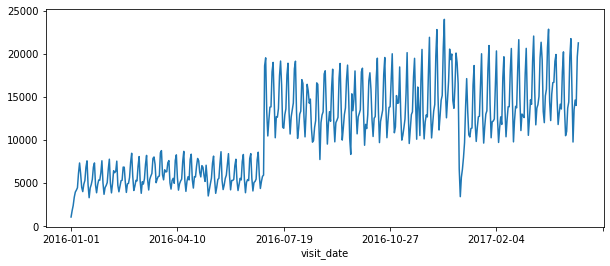

In [4]:
fig = plt.figure(figsize = (10, 4))
air_visit.groupby(['visit_date'])['visitors'].sum().plot()

- 주기적인 패턴이보인다 => 주, 월별로 분석해볼 생각을 할 수 있다.
- 16년 7월쯤 급격히 증가한다,

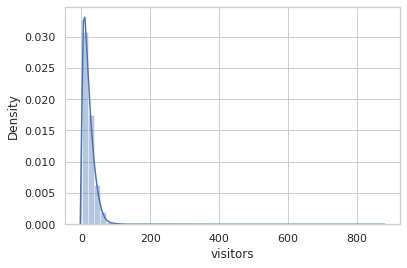

In [27]:
sns.distplot(air_visit['visitors'])

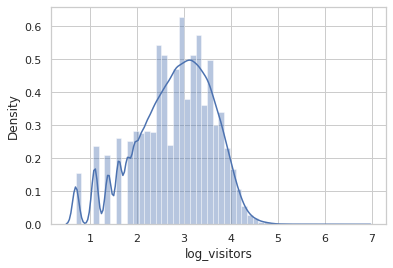

In [30]:
air_visit['log_visitors'] = np.log1p(air_visit['visitors'])
sns.distplot(air_visit['log_visitors'])

- 각 날짜별 가게에 방문자 수들간에 심하게 치우쳐짐을 확인가능하다

Text(0, 0.5, 'median_visitor')

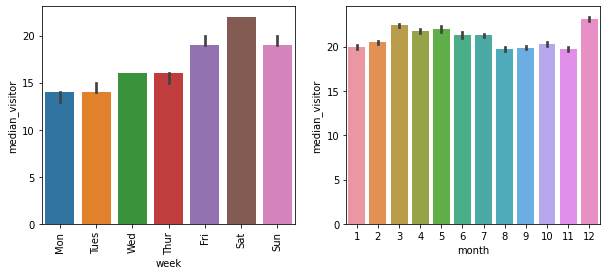

In [6]:
from numpy import median
f, ax = plt.subplots(1, 2, figsize = (10, 4))
air_visit['dow'] = pd.to_datetime(air_visit['visit_date']).dt.dayofweek
air_visit['month'] = pd.to_datetime(air_visit['visit_date']).dt.month
sns.barplot('dow','visitors',data = air_visit, estimator=median, ax = ax[0])
ax[0].set_xlabel('week')
ax[0].set_ylabel('median_visitor')
ax[0].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
sns.barplot('month','visitors',data = air_visit, ax = ax[1])
ax[1].set_ylabel('median_visitor')

Text(0, 0.5, 'mean_visitor')

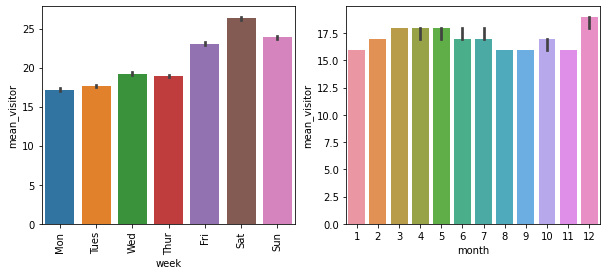

In [7]:
f, ax = plt.subplots(1, 2, figsize = (10, 4))
air_visit['dow'] = pd.to_datetime(air_visit['visit_date']).dt.dayofweek
air_visit['month'] = pd.to_datetime(air_visit['visit_date']).dt.month
sns.barplot('dow','visitors',data = air_visit, ax = ax[0])
ax[0].set_xlabel('week')
ax[0].set_ylabel('mean_visitor')
ax[0].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
sns.barplot('month','visitors',data = air_visit, estimator=median, ax = ax[1])
ax[1].set_ylabel('mean_visitor')

## 2. Air Reservation 

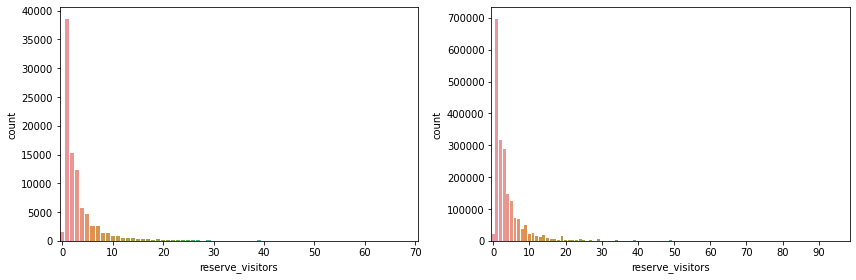

In [8]:
f, ax = plt.subplots(1, 2, figsize= (12, 4))
sns.countplot('reserve_visitors', data = air_reserve, ax = ax[0])
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(10))
ax[0].xaxis.set_major_formatter(ticker.ScalarFormatter())
sns.countplot('reserve_visitors', data = hpg_reserve, ax = ax[1])
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(10))
ax[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tight_layout()
plt.show()

## 3. Air Store

공간적인 측면을 시각화시켜 보자.

data 설명에 따르면 ’latitude’와 ’longitude’는 가게가 있는 지역의 ’위도’와 ’경도’이다.

다음 지도는 air restaurants의 인터랙티브 맵이고, 클러스터를 클릭하면 지도가 확대된다.
지도는 많은 가게가 같은 좌표를 공유한다는 걸 보여준다.

In [9]:

import folium
from folium.plugins import MarkerCluster

m = folium.Map((air_store['latitude'][100], air_store['longitude'][100]),zoom_start=6)
cluster = MarkerCluster().add_to(m)

for i in air_store.index:
    sub_lat =  air_store.loc[i, 'latitude']
    sub_long = air_store.loc[i, 'longitude']

    #지도에 데이터 찍어서 보여주기
    folium.Marker(location = [sub_lat,sub_long]).add_to(cluster)

m

그 외에도 공간적인 위치를 나타내는 정보인 'air_area_name'이 있다.

실제로 좌표와 지역정보는 공통된 부분이 많다.

In [10]:
print(f"지역 정보의 종류 : {len(air_store['air_area_name'].unique())}")
print(f"좌표 정보의 종류 : {len(air_store.groupby(['latitude','longitude'])['store_id'].unique())}")
print(f"지역과 위치의 합집합의 종류 : {len(air_store.groupby(['latitude','longitude','air_area_name'])['store_id'].unique())}")

지역 정보의 종류 : 103
좌표 정보의 종류 : 108
지역과 위치의 합집합의 종류 : 108



위의 결과 처럼 지역정보는 모두 좌표정보에 포함되어 있지만,
두 개의 데이터의 종류는 5개 밖에 차이나지 않는다.

따라서 공간적인 특성을 보는데는 지역정보만을 사용해도 큰 오차가 없을 것이라고 생각된다.

다음은 여러 가게의 타입 분포를 나타낸다.


In [11]:
genre_counts = air_store_c['air_genre_name'].value_counts()
genre_counts

Izakaya                         197
Cafe/Sweets                     181
Dining bar                      108
Italian/French                  102
Bar/Cocktail                     79
Japanese food                    63
Other                            27
Yakiniku/Korean food             23
Western food                     16
Okonomiyaki/Monja/Teppanyaki     14
Creative cuisine                 13
Karaoke/Party                     2
Asian                             2
International cuisine             2
Name: air_genre_name, dtype: int64

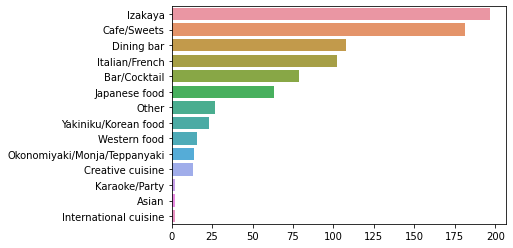

In [12]:
sns.barplot(y= genre_counts.index, x= genre_counts.values)
plt.show()

그리고가장 많은 가게가 있는 지역 top15를 차트로 나타내겠다.

In [13]:
restaurants_per_area = air_store['air_area_name']
restaurants_per_area.index = air_store['air_genre_name']

restaurants_per_area = restaurants_per_area.value_counts()
restaurants_per_area

Fukuoka-ken Fukuoka-shi Daimyō      64
Tōkyō-to Shibuya-ku Shibuya         58
Tōkyō-to Minato-ku Shibakōen        51
Tōkyō-to Shinjuku-ku Kabukichō      39
Tōkyō-to Setagaya-ku Setagaya       30
                                    ..
Tōkyō-to Musashino-shi Midorichō     2
Ōsaka-fu Ōsaka-shi Fuminosato        2
Tōkyō-to Koganei-shi Honchō          2
Tōkyō-to Fuchū-shi Miyanishichō      2
Hyōgo-ken Kōbe-shi Motomachidōri     2
Name: air_area_name, Length: 103, dtype: int64

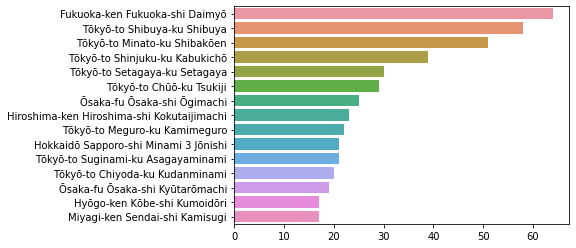

In [14]:
restaurants_per_area_top15 = restaurants_per_area[:15]
sns.barplot(y= restaurants_per_area_top15.index, x= restaurants_per_area_top15.values)
plt.show()

이자카야 타입이 가장 많고, 다음이 카페이다. ‘Karaoke’와 ’International’, ‘Asian’ 타입 식당은 적어 보인다.

후쿠오카는 면적당 air restaurants가 가장 많다. 그 뒤를 이어 Tokyo 지역이다.

이 같은 분포는 지역마다의 어느정도의 보장된 유동인구수를 나타낸다고도 할 수 있다.

##4. Holidays

먼저, holiday일 때와 아닐 때의 방문자 수를 비교해보자

[Text(0, 0, 'False'), Text(0, 0, 'Ture')]

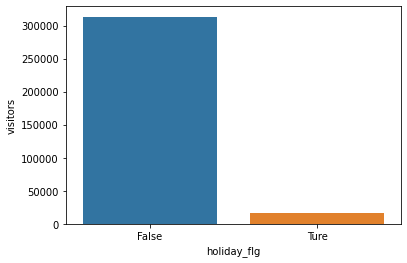

In [17]:
train_size = len(air_visit)
train = data[:train_size]
df=train['visitors'].groupby(train['holiday_flg']).sum().reset_index()
ax=sns.barplot(x='holiday_flg', y='visitors', data=df)
ax.set_xticklabels(['False','Ture'], fontsize=10)

data에서 휴일의 비율은 약 7%이다

그 다음으로는 2017년의 예측 기간 data와 2016년의 동일 기간(골든 위크) data의 분포를 나타내는 차트를 보자.

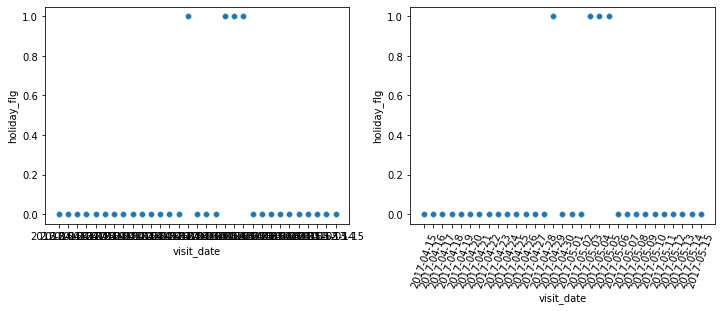

In [18]:
df=pd.to_datetime(data['visit_date'])
df1=(df>="2016-04-15") & (df<="2016-05-15")

df1=data[df1]
df1 = df1.sort_values(by='visit_date' ,ascending=True)

f, ax = plt.subplots(1, 2, figsize= (12, 4))

sns.scatterplot(x="visit_date", y="holiday_flg" ,data=df1, ax = ax[0])
ax[0]=plt.xticks(rotation = 'vertical')
degrees = 70
ax[0]=plt.xticks(rotation=degrees)

df2=(df>="2017-04-15") & (df<="2017-05-15")
df2=data[df2]

sns.scatterplot(x="visit_date", y="holiday_flg"  ,data=df2, ax = ax[1])
ax[1]=plt.xticks(rotation = 'vertical')
ax[1]=plt.xticks(rotation=degrees)


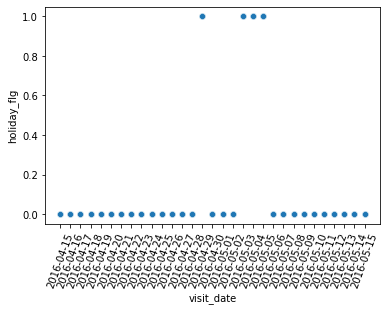

In [19]:
df=pd.to_datetime(data['visit_date'])
df1=(df>="2016-04-15") & (df<="2016-05-15")

df1=data[df1]
df1 = df1.sort_values(by='visit_date' ,ascending=True)
sns.scatterplot(x="visit_date", y="holiday_flg" ,data=df1)
p=plt.xticks(rotation = 'vertical')

degrees = 70
p=plt.xticks(rotation=degrees)

2016년의 골든위크와 2017년의 골든위크가 거의 겹친다. 이것은  골든위크가 중요한 feature가 된다 라는걸 의미한다.

# Feature Enginneering

## 1 The impact of holidays

휴일인 날과 그렇지 않은 날의 통계를 비교하여 휴일이 방문객 수에 영향을 미치는지 알아보자.

[Text(0, 0, 'True'), Text(0, 0, 'False')]

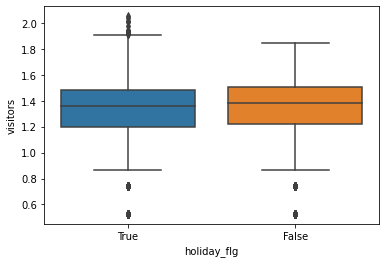

In [20]:
ax=sns.boxplot(x="holiday_flg", y="visitors",  data=train)
ax.set_xticklabels(['True','False'], fontsize=10)

전체 방문자 수를 보니 큰차이는 없어 보인다. 그러나 요일별로 보게 되면,,

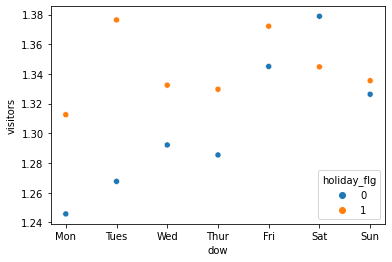

In [21]:
df=train.copy()
df1=train.groupby(['dow','holiday_flg'])['visitors'].mean().reset_index()
df1.head()
ax=sns.scatterplot(x="dow", y="visitors", hue='holiday_flg' ,data=df1)
ax.set_xticklabels(['','Mon','Tues',"Wed","Thur","Fri","Sat",'Sun']);

휴일이 주말(토, 일)일때는 방문자 수에 큰 영향을 미치지 않고 꾸준히 사람이 많으며 오히려 토요일에는 감소한 경우도 있다. 하지만 휴일이 주중인 경우는 큰영향을 미치는 걸로 보인다.(특히 월요일 화요일) 이로 인해 date 보다는 요일 정보(day of week :dow)가 중요하다는걸 알 수 있다.

In [16]:
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)
date_info['golden_week'] = (((date_info['visit_date'].str[5:7] == '04') & (date_info['visit_date'].str[8:10].isin(['29','30']))) |\
                            ((date_info['visit_date'].str[5:7]== '05') & (date_info['visit_date'].str[8:10].isin(['01','02', '03', '04', '05'])))|
                           ((date_info['visit_date'].str[0:5]== '2017') & (date_info['visit_date'].str[5:7]== '05') & (date_info['visit_date'].str[8:10].isin(['06','07'])))).astype(int)
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2','golden_week']], on=['visit_date'],how='left')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284127 entries, 0 to 284126
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   store_id          284127 non-null  object 
 1   visit_date        284127 non-null  object 
 2   visitors          284127 non-null  float64
 3   id                284127 non-null  object 
 4   air_genre_name_x  284127 non-null  int64  
 5   air_area_name_x   284127 non-null  object 
 6   latitude_x        284127 non-null  float64
 7   longitude_x       284127 non-null  float64
 8   air_area_name0_x  284127 non-null  int64  
 9   genre_name_x      284127 non-null  object 
 10  dow               284127 non-null  int64  
 11  air_genre_name_y  284127 non-null  int64  
 12  air_area_name_y   284127 non-null  object 
 13  latitude_y        284127 non-null  float64
 14  longitude_y       284127 non-null  float64
 15  air_area_name0_y  284127 non-null  int64  
 16  genre_name_y      28

## 2.Restaurants per area and the effect on visitor numbers

만약 식당이 유명하거나, 그 지역에 동일한 타입의 식당이 하나뿐이라면 많은 고객을 예상할 수 있을 것 같다.

거리에 동일 타입내 12개의 다른 식당이 있다면 사람들은 여러 곳으로 갈 것이다.

그러나 data set과 같은 snapshot이거나, 지역화 특성이 된 곳의 식당은 여전히 경쟁력이 있다.
그래서 지역별 특정 장르의 식당 수와 그것들이 방문객 수에 미치는 영향을 알아본다.

다음 차트는 지역당 장르별 빈도수를 나타낸다.
어떤 장르가 어디 영역에 존재하는지를 나타내는 차트를 만들겠다.
점의 크기는 같은 지역에 있는 같은 장르의 가게 수이다.

In [24]:
air_copy = air_store.copy()
air_copy.sort_values(by=['air_area_name'])
air_copy['area'] = air_copy['air_area_name'].apply(lambda x: x[:12])
air_copy['gs_p_a'] = air_copy.groupby(['air_genre_name','area'])['store_id'].transform('count')
len(air_copy['area'].unique())
air_copy = air_copy.sort_values(by=['area'])

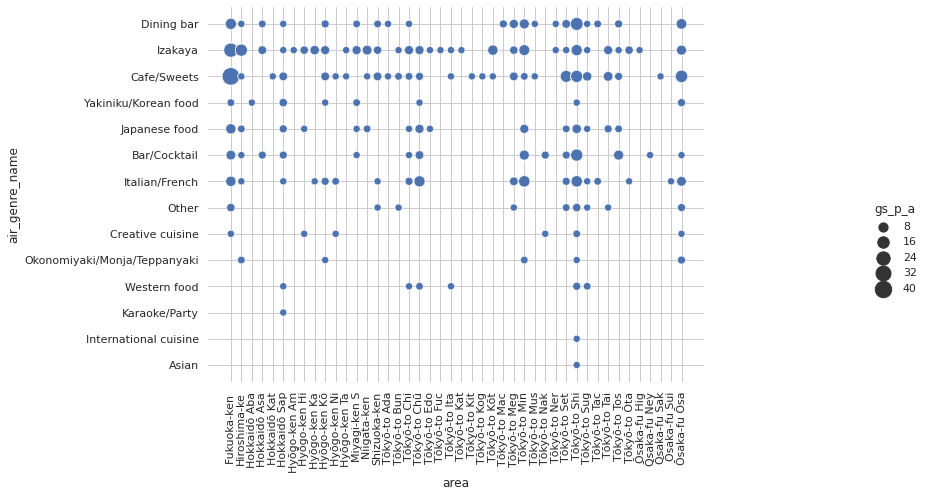

In [32]:
sns.set_theme(style="whitegrid")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=air_copy,
    x= 'area', y='air_genre_name', size='gs_p_a',
    palette=cmap, sizes=(50, 300))

g.despine(left=True, bottom=True)
g.set_xticklabels(rotation=90)
plt.gcf().set_size_inches(22, 6)
plt.show()

몇 몇 지역에는 많고 다양한 레스토랑이 있지만, 어떤 지역에는 하나의 레스토랑만 있다.
parameter 공간의 대부분은 비어있다.

유사하게, ‘Izakaya’, ‘Cafe’와 같은 식당은 어디는 흔하지만, 어디는 그렇지 않다.
정말 특이하게도 'karaoke', 'International', 'Asian'은 한 지역에만 2개씩 밖에 존재하지 않는다.

다음 차트는 지역별 식당들의 장르 분포도를 보여준다.
같은 장르에서는 boxplot으로 세부 분포를 볼 수 있다.
장르는 지역별 분포 평균의 내림차순으로 정렬했으며, 차트에서 dot는 수평으로 나타냈다.
y축은 점의 크기에 해당한다.

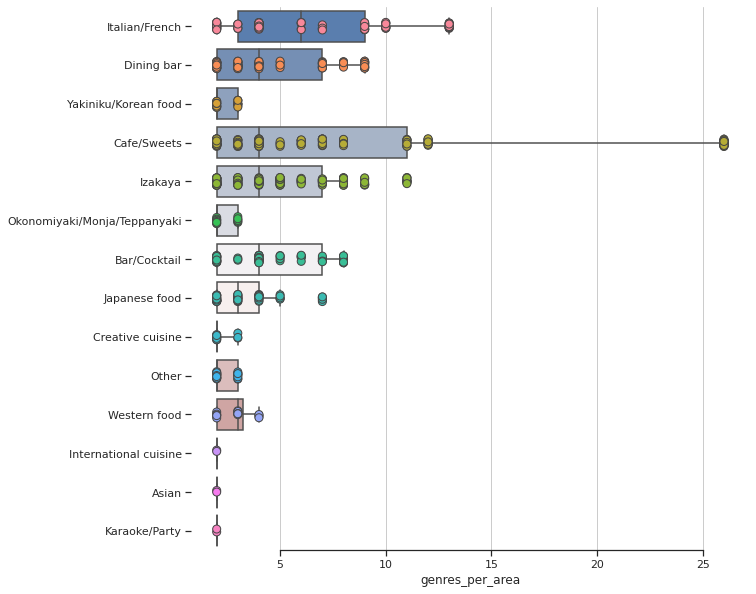

In [71]:
air_store['genres_per_area'] = air_store.groupby(['air_genre_name','air_area_name'])['store_id'].transform('count')
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 10))


# Plot the orbital period with horizontal boxes
sns.boxplot(x="genres_per_area", y="genre_name", data=air_store,
            whis=[0, 90], palette="vlag")

# Add in points to show each observation
sns.stripplot(x="genres_per_area", y="genre_name", data=air_store,
              size=8, linewidth=1)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
plt.show()


단지 몇 몇 장르만이 지역당 2개 이상의 레스토랑 중위값을 가지고 있다.
예를 들어 ‘Italian/French’, ’Bar/Cocktail’은 지역당 2개 이상의 그룹을 찾을 수 있다.

대다수 장르의 분포는 지역당 2개 정도의 클러스터에 밀집되어 있고, ’Cafes’는 한 지역에 26개의 많은 가게가 있다.

흥미롭게도 최소값은 1이 아니라 2다.
즉 어느 지역에도 장르를 독점한 ‘air’ 레스토랑이 없다는 것이다.
차트에서도 보듯이, 동일 지역에 2개의 레스토랑 그룹이 있으면 그들은 동일한 장르이다.

각 영역의 장르 수에 대한 정보를 바탕으로 데이터 집합의 클러스터링 또는 ‘복잡성’를 정량화하고 이걸 고객 수와 연관시킬 수 있다.

더해서, 각 클러스터링 사례의 평균 고객 수를 추정한다.
이를 위해 먼저 지역당 장르의 log1p로 변환된 고객 수의 평균을 구하고,
각 경우(한 지역에 동일한 장르의 발생수)에 대해 평균 및 표준편차를 계산할 것이다.

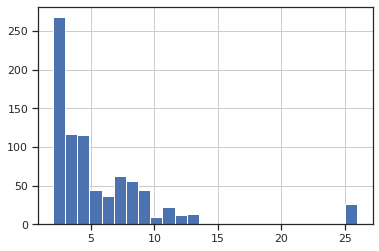

In [73]:
air_store['genres_per_area'].hist(bins = 25)
plt.show()

In [95]:
train['genres_per_area'] = air_store.groupby(['air_genre_name','air_area_name'])['store_id'].transform('count')
train['visitors_per_genre_area_mean'] = train.groupby(['air_genre_name', 'air_area_name'])['visitors'].transform('mean')
train['visitors_per_genre_area_mean']

0         2.824852
1         2.824852
2         2.824852
3         2.824852
4         2.824852
            ...   
252103    2.074609
252104    2.074609
252105    2.074609
252106    2.074609
252107    2.074609
Name: visitors_per_genre_area_mean, Length: 252108, dtype: float64

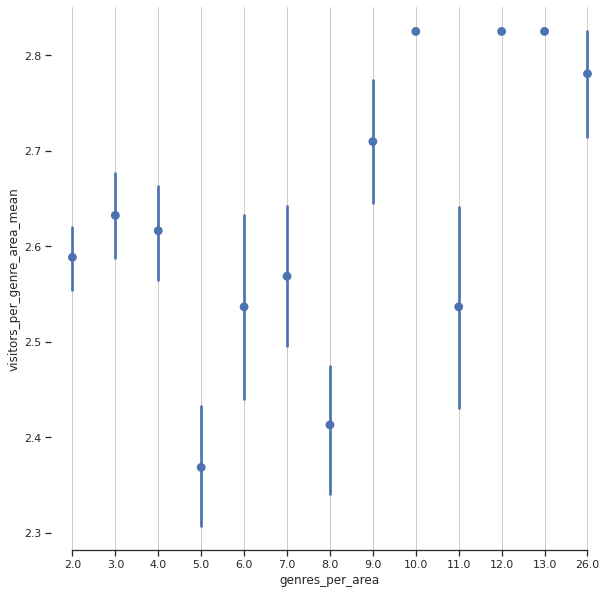

In [96]:

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 10))

sns.pointplot(x='genres_per_area', y='visitors_per_genre_area_mean',
    data=train, dodge=True, join=False)

# Tweak the visual presentation
ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
plt.show()

## 장르와 요일, 월간의 관계